# Assignment: Message-Passing Neural Networks
Yixin (Allen) Hu

## Question 1: Making data loaders

The objective of this part of the assignment is to load in the data from the .proto files and read them in by using the data loader that has been provided in the mpnn file (with modifications)

In [1]:
%matplotlib inline
import sys
from matplotlib import pyplot as plt
from mpnn.data import make_data_loader
from mpnn.layers import Scaling
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import tensorflow as tf
import numpy as np
import warnings
from tqdm import tqdm

First, ignore warnings so that the file isn't huge

In [2]:
warnings.filterwarnings('ignore')

Making the data loader...

In [4]:
training_loader = make_data_loader('datasets/train_data.proto', batch_size=32, shuffle_buffer=8172)

In [5]:
validation_loader = make_data_loader('datasets/valid_data.proto',batch_size=32)

In [6]:
test_loader = make_data_loader('datasets/test_data.proto',batch_size=32)

### It's generally a rule of thumb to enable "shuffle" when creating the training data loader. Why is that? Which parameter do you set?

I have set the shuffle_buffer to be 7561 (random large prime number), that is to say, every time we draw data from the training set, it will have an offset of 7561 'observations'. This is important because the shuffle allows us to sample different combinations of data from our training data. In doing so, we would be able to use different training sets for our model, and thus increasing the overall confidence of the model by reducing the possibility of *overfitting*.

In [8]:
res = []
run = True

if run == True:
    for idx in range (100):
        inputs, outputs = next(iter(training_loader))
        res.append(np.mean(outputs))

2022-02-21 14:08:17.831006: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-21 14:08:17.832739: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3593265000 Hz


### Sample a few batches from the training data, what is the average of the output variable?

After sampling 100 batches with shuffle enabled, I was able to retrieve the following mean of the output variable "u0_atom".

In [9]:
print(f'The mean of output variable is around: {np.mean(res)}')

The mean of output variable is around: -2.791029930114746


## Question 2: Training a network for real

The main objective for this part of the assignment is to follow the steps outlined by the write-up and construct a custom mpnn model. First, adopting the MessagePassingLayer Class from the MPNN notebook:

In [10]:
class MessagePassingLayer(layers.Layer):
    """
    Perform the message passing step
    Note: This function is directly adopted from the the applied-ai-for-materials
    MPNN notebook
    """

    def call(self, atom_features, bond_features, connectivity):
        """Perform the message passing steps.
        
        Takes the atom and bond features with the connectivity as inputs
        and produces a new set of atom features.
        """
        # Get the features for the atoms at each side of a bond
        source_atom = tf.gather(atom_features, connectivity[:, 0])
        target_atom = tf.gather(atom_features, connectivity[:, 1])

        # Make messages based on the "far side" of the bond and the bond type
        all_messages = tf.multiply(bond_features, target_atom)

        # Sum them up and add them to the original features
        messages = tf.math.segment_sum(all_messages, connectivity[:, 0])
        atom_features = atom_features + messages
        return atom_features

In [11]:
class Readout(layers.Layer):
    """
    Convert atomic to molecular features
    Note: This function is directly adopted from the the applied-ai-for-materials
    MPNN notebook
    """
    
    def call(self, atom_features, node_graph_indices, readout_fn='sum'):
        if(readout_fn == 'sum'):
            return tf.math.segment_sum(atom_features, node_graph_indices)
        elif(readout_fn =='max'):
            return tf.math.segment_max(atom_features, node_graph_indices)

Now, we add modiciations to the make_model function from the MPNN notebook, where we:

1. Add a parameter that allows you change to which readout function is used for the Readout layer.

2. Add a Dense layer with 'relu' activation and 32 units between the readout and the output layer.

3. Add "scaling layer" from mpnn.layers (i.e., from mpnn.layers import Scaling) after the current output layer, use the output of the scaling layer as the output of the model. Pass your Scaling layer a name of "scaling" (i.e., Scaling(name='scaling'))

In [12]:
def make_model(num_features: int, num_messages: int, set_readout_fn='sum'):
    """Build an MPNN
    
    
    Args:
        num_features: Number of features to use to describe each atom and bond
        num_messages: Number of message passing steps
    Returns:
        Keras models that generate molecule property
    """
    
    # The first step is to define which inputs to expand and their shapes/types
    node_graph_indices = layers.Input(shape=(1,), name='node_graph_indices', dtype='int32')
    atom_types = layers.Input(shape=(1,), name='atom', dtype='int32')
    bond_types = layers.Input(shape=(1,), name='bond', dtype='int32')
    connectivity = layers.Input(shape=(2,), name='connectivity', dtype='int32')

    # Squeeze the node graph and connectivity matrices
    #  Keras makes all input arrays 2D, I find it easier to deal with them as 1D vectors
    #  The squeeze operation removes the second dimension, and I use Kera's Lambda layer
    #  to quickly wrap a simple Tensorflow function
    squeeze = layers.Lambda(tf.squeeze, arguments={'axis': 1}, name='squeeze')
    snode_graph_indices = squeeze(node_graph_indices)
    satom_types = squeeze(atom_types)
    sbond_types = squeeze(bond_types)
    
    # Generate initial features for each atom and bond using embeddings
    atom_features = layers.Embedding(6, num_features, name='atom_embedding')(satom_types)
    bond_features = layers.Embedding(4, num_features, name='bond_embedding')(sbond_types)
    
    # Perform a few message passing steps
    message_layer = MessagePassingLayer(name='message_passing')
    for _ in range(num_messages):
        atom_features = message_layer(atom_features, bond_features, connectivity)
        
    # Reduce to a single set of features per molecule
    mol_features = Readout(name='readout')(atom_features, snode_graph_indices,readout_fn=set_readout_fn)
        
    # Add dense layer with 'relu' activation and 32 units
    dense_relu = layers.Dense(32, activation='relu', name='dense_relu')(mol_features)

    # Create the output layer
    output_raw = layers.Dense(1, activation='linear', name='output_raw')(dense_relu)
    
    # Add Scaling layer
    output_scaled = Scaling(name='scaling')(output_raw)
    
    # Create the models by defining which layers are the inputs and which are the outputs
    model = Model(inputs=[node_graph_indices, atom_types, bond_types, connectivity], outputs=output_scaled)
    return model

In [13]:
model = make_model(64,2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
bond (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
squeeze (Lambda)                (None,)              0           node_graph_indices[0][0]         
                                                                 atom[0][0]                       
                                                                 bond[0][0]                       
______________________________________________________________________________________________

Building models with 0, 1, 2, 4, and 8 message passing layers and plotting their changes in best loss on the test set as a function of number of layers. Of course, we will have to first preseed (scale) our model. Lastly, we will get ready to train our model using an early stopping call-back. Combining all of these into one block of code:

In [24]:
n_mp_layers = [0,1,2,4,8]
res = []
callback = EarlyStopping(monitor='loss',patience=8,restore_best_weights=True)

for n in tqdm(n_mp_layers):
    
    #making the model
    model = make_model(64, n)
    
    #scaling the model
    scale = model.get_layer('scaling')
    scale.mean = outputs.numpy().mean()
    scale.std = outputs.numpy().std()
    
    #making early stopping callback and training the model 
    model.compile("adam",loss='mean_squared_error')
    model.fit(training_loader,epochs=128,batch_size=32,verbose=False,callbacks=[callback],validation_data=validation_loader)
    
    #appending the results
    res.append({
        'messages': n,
        'loss':model.evaluate(test_loader, verbose=False)
    })
    
#This takes about 6 min at 20 epochs

100%|████████████████████████████████████████████████████████████████████████| 5/5 [14:58<00:00, 179.64s/it]


Text(0, 0.5, 'Test Loss (MSE)')

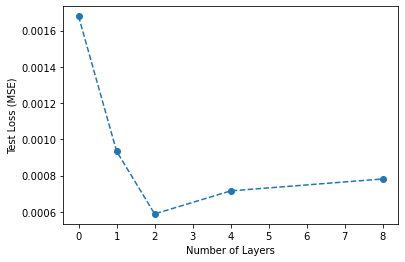

In [27]:
fig, ax = plt.subplots()

results = pd.DataFrame(res).sort_values('messages')

ax.plot(results['messages'],results['loss'], '--o')

ax.set_xlabel("Number of Layers")
ax.set_ylabel("Test Loss (MSE)")

Notice that as we increase layers, the MSE decreases. Although there is some increase in MSE as layers approach 8, this could possibly be due to random idiosyncracies within the model, and the increase is barely 0.0002, which depending on the context, arguably insignificant. 

### Question 3: Evaluate Different Readout Layers

Train a total of 4 models each with 4 message passing steps and 64 features but varying whether we use u0_atom or bandgap to fit the model and whether we use "sum" or "max" as a readout function:

First to make the loaders:

In [30]:
training_loader_u0 = make_data_loader('datasets/train_data.proto', batch_size=32, shuffle_buffer=8172,output_property="u0_atom")
training_loader_bg = make_data_loader('datasets/train_data.proto', batch_size=32, shuffle_buffer=8172,output_property="bandgap")

validation_loader_u0 = make_data_loader('datasets/valid_data.proto',batch_size=32,output_property="u0_atom")
validation_loader_bg = make_data_loader('datasets/valid_data.proto',batch_size=32,output_property="bandgap")

test_loader_u0 = make_data_loader('datasets/test_data.proto',batch_size=32,output_property="u0_atom")
test_loader_bg = make_data_loader('datasets/test_data.proto',batch_size=32,output_property="bandgap")

Now setting up the models with different readouts

In [42]:
otpt_lst = ["u0_atom","bandgap"]
readout_lst = ["sum","max"]
res_q3 = []

for otpt_var in tqdm(otpt_lst):
    for readout_type in readout_lst:
        #making the model
        model = make_model(64, 4,set_readout_fn=readout_type)

        #scaling the model
        scale = model.get_layer('scaling')
        scale.mean = outputs.numpy().mean()
        scale.std = outputs.numpy().std()

        #making early stopping callback and training the model 
        model.compile("adam",loss='mean_squared_error')
        if otpt_var == "u0_atom":
            model.fit(training_loader_u0,epochs=30,batch_size=32,verbose=False,callbacks=[callback],validation_data=validation_loader_u0)
            
            #appending the results
            res_q3.append({
            'output': otpt_var,
            'readout': readout_type,
            'y_preds':model.predict(test_loader_u0),
            'y_trues':np.hstack([x[1] for x in test_loader_u0]),
            'loss':model.evaluate(test_loader_u0, verbose=False)
        })  
            
        else:
            model.fit(training_loader_bg,epochs=10,batch_size=32,verbose=False,callbacks=[callback],validation_data=validation_loader_bg)
            
            #appending the results
            res_q3.append({
            'output': otpt_var,
            'readout': readout_type,
            'y_preds':model.predict(test_loader_bg),
            'y_trues':np.hstack([x[1] for x in test_loader_bg]),
            'loss':model.evaluate(test_loader_bg, verbose=False)
        })
            
        print(f'done processing [{otpt_var},{readout_type}]')

  0%|                                                                                 | 0/2 [00:00<?, ?it/s]

done processing [u0_atom,sum]


 50%|████████████████████████████████████                                    | 1/2 [04:15<04:15, 255.43s/it]

done processing [u0_atom,max]
done processing [bandgap,sum]


100%|████████████████████████████████████████████████████████████████████████| 2/2 [05:38<00:00, 169.29s/it]

done processing [bandgap,max]


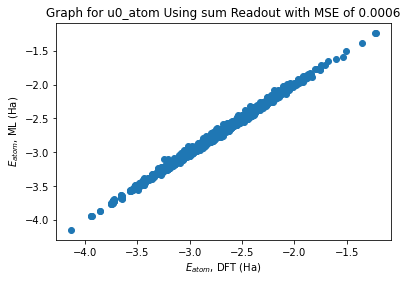

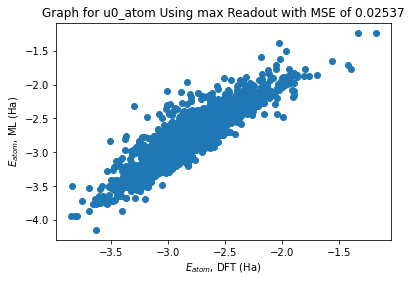

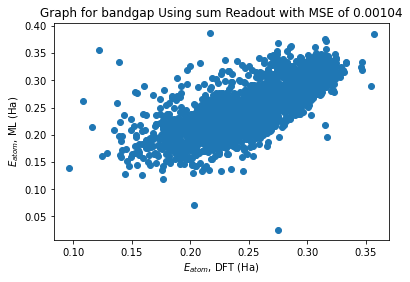

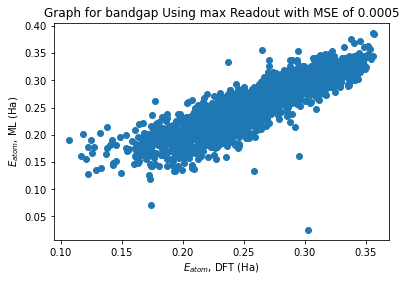

In [57]:
results = pd.DataFrame(res_q3)


for index, row in results.iterrows():
    fig, ax = plt.subplots()
    ax.scatter(row['y_preds'], row['y_trues'])
    ax.set_xlabel('$E_{atom}$, DFT (Ha)')
    ax.set_ylabel('$E_{atom}$, ML (Ha)')
    ax.set_title(f'Graph for {row["output"]} Using {row["readout"]} Readout with MSE of {round(row["loss"],5)}')

Notice that some readout functions are better than others, even if everything else in the model is the same. Since band gaps do not have scaling behavior, we are able to fit a better graph (lower MSE) using the *max* readout relative to the *sum* readout. Vice versa, atomization energy scales with the size of the molecule, so using *sum* as our callout reflects the underlying physics: more atoms implies larger energies.  